# 0. Preprocesiranje i ucitavanje biblioteka 

In [44]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
cmake                        3.29.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
dlib                         19.24.4
executing                    2.

In [45]:
#pip  install --user --upgrade pip
#pip install --upgrade --user pip setuptools
#!pip install opencv-python matplotlib imageio gdown tensorflow

In [46]:
import os
import gdown
import cv2
import dlib
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
from collections import defaultdict

import imageio
from tensorflow.python.client import device_lib

In [47]:
tf.config.list_physical_devices('GPU')

[]

In [48]:
#vraca graficke karte na racunaru
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#print(get_available_devices())

In [49]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('NO GPU')
    pass

NO GPU


# 1. Ucitavanje podataka

In [50]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('data.zip')

In [51]:
def load_video(path:str, width: int = 64, height: int = 64) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []

  
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
       
        faces = detector(gray_frame)
        for face in faces:

            #nalazimo lice na slici(frejmu) i obelezavamo tacke koje oznacavaju usne
            #secemo sliku 64x64 oko usana i takav frejm ubacujemo u neuralnu mrezu
            
            landmarks = predictor(gray_frame, face)
            
        
            lip_left = landmarks.part(48).x
            lip_right = landmarks.part(54).x
            lip_top = min(landmarks.part(50).y, landmarks.part(51).y)
            lip_bottom = max(landmarks.part(58).y, landmarks.part(59).y)

          
            lip_frame = frame[lip_top:lip_bottom, lip_left:lip_right]
            
            
            lip_frame_resized = cv2.resize(lip_frame, (width, height))  
            #resajzujemo sliku oko usta na 64x64
            
           
            lip_frame_gray = cv2.cvtColor(lip_frame_resized, cv2.COLOR_BGR2GRAY)
            
            
            frames.append(lip_frame_gray)

    cap.release()

    # Convert frames to tensor
    frames = tf.convert_to_tensor(frames, dtype=tf.float32) #pretvaramo u tensor da bi mogli da koristimo u NN

    #standardizujemo sliku
    mean = tf.reduce_mean(frames)
    std = tf.math.reduce_std(frames)

    return tf.cast((frames - mean), tf.float32) / std

In [53]:
#################################
# tokenizujemo sve karaktere da budu oznaceni sa jedinstvenim brojem
# num_to_char da vratimo oznake iz broja u karakter da bi mogli da impretiramo yhat
#####################################
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [54]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [55]:
char_to_num(['p','r','o','j','e','k','a','t'])

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([16, 18, 15, 10,  5, 11,  1, 20], dtype=int64)>

In [56]:
num_to_char([16, 18, 15, 10,  5, 11,  1, 20])

<tf.Tensor: shape=(8,), dtype=string, numpy=array([b'p', b'r', b'o', b'j', b'e', b'k', b'a', b't'], dtype=object)>

In [57]:
# funkcija load_aligments ucitava ground truth labels svakog od videa u bazi

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
            
    token_array = np.array(char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1))), dtype=np.int32)
    return token_array

In [58]:
# funkcija load_data ucitava aligments(labele), 
# ucitava video i izdvaja automatski usne na video snimku

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
   
    return frames, alignments

In [59]:
#test_path = '.\\data\\s4\\bbae8n.mpg'

In [60]:
#tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

In [61]:
#frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [62]:
#alignments

In [63]:
#len(frames)

In [64]:
#alignments

In [65]:
#tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments).numpy()])

In [66]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [67]:
#frames.shape

# 2. pravljenje PipeLine za podatke

In [68]:
from matplotlib import pyplot as plt

In [69]:
#videe iz baze podataka stavljamo u promenjivu data 
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

#meša redosled datoteka (do 500 datoteka) bez ponovnog mešanja pri svakoj iteraciji
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# grupise podatke u batcheve veličine 2 i vrši padding na dimenzije ([75,64,64],[40])
data = data.padded_batch(2, padded_shapes=([75,64,64],[40])) 

# prefetching za optimizaciju performansi (učitava podatke unapred asinhrono)
data = data.prefetch(tf.data.AUTOTUNE)

#train je prvih 450 videa
train = data.take(450)

#test je poslednjih 50 videa
test = data.skip(450)

In [70]:
len(data)

500

In [71]:
len(test)

50

In [72]:
frames, alignments = data.as_numpy_iterator().next()

In [73]:
len(frames)

2

In [74]:
sample = data.as_numpy_iterator()

In [75]:
val = sample.next(); val[0]

array([[[[1.3288715 , 1.2521505 , 1.1754296 , ..., 1.0987087 ,
          1.0603483 , 1.0603483 ],
         [1.3288715 , 1.2521505 , 1.1754296 , ..., 1.0987087 ,
          1.0603483 , 1.0603483 ],
         [1.3288715 , 1.2521505 , 1.1754296 , ..., 1.0987087 ,
          1.0987087 , 1.0603483 ],
         ...,
         [1.3288715 , 1.4055923 , 1.5206736 , ..., 1.0219878 ,
          1.0987087 , 1.1754296 ],
         [1.3288715 , 1.4055923 , 1.5206736 , ..., 1.0219878 ,
          1.0987087 , 1.1754296 ],
         [1.3288715 , 1.4055923 , 1.5206736 , ..., 1.0219878 ,
          1.0987087 , 1.1754296 ]],

        [[1.290511  , 1.2521505 , 1.21379   , ..., 0.9836274 ,
          0.94526696, 0.94526696],
         [1.290511  , 1.2521505 , 1.21379   , ..., 0.9836274 ,
          0.94526696, 0.94526696],
         [1.290511  , 1.2521505 , 1.21379   , ..., 1.0219878 ,
          0.9836274 , 0.94526696],
         ...,
         [1.290511  , 1.3288715 , 1.3672318 , ..., 0.94526696,
          0.9836274 , 1.0

In [113]:
prezentacija = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf2n.mpg'))

In [77]:
frames_array = prezentacija[0][1]
print("Frames array shape:", frames_array.shape)
print("Frames array data type:", frames_array.dtype)

# Convert frames to uint8 and scale to [0, 255]
frames_array_uint8 = np.uint8(frames_array * 255)

# Squeeze the frames array to remove the singleton dimension
frames_array_uint8_squeezed = np.squeeze(frames_array_uint8)

Frames array shape: (64, 64)
Frames array data type: <dtype: 'float32'>


In [78]:
imageio.mimsave('./data/animation.mpg', frames_array_uint8_squeezed, fps=10, codec = 'mpeg2video')

ValueError: Image data must be a sequence of ndimages.

In [114]:
alligments_array = prezentacija[1]
alligments_array

array([39,  2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23,
       15, 39, 14, 15, 23])

In [ ]:
39,  2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23,
       15, 39, 14, 15, 23

In [ ]:
np.shape(alligments_array)

Alignments 2. video
[39 19  5 20 39  2 12 21  5 39  1 20 39  1 39  6 15 21 18 39 14 15 23  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


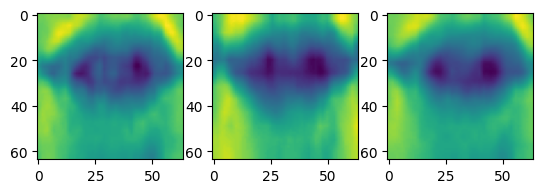

In [115]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(val[0][1][25]) 
axs[1].imshow(val[0][1][35]) 
axs[2].imshow(val[0][1][24]) 
print('Alignments 2. video')
print(val[1][1])

#indeks 0: video, indeks 1: n-ti video iz Batcha, indeks3: vrati n-ti frame(0 do 74)

In [116]:
print('Decoded words for 2. video')
tf.strings.reduce_join([num_to_char(word) for word in alligments_array])

Decoded words for 2. video


<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at f two now'>

# 2. Dizajn Neuralne mreže

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Dense, GRU, Dropout, Bidirectional, MaxPool3D
from tensorflow.keras.layers import Flatten, Activation, TimeDistributed 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal

In [83]:
data.as_numpy_iterator().next()[0][0].shape

(75, 64, 64)

In [84]:
# pravimo model koji je najvecim delom CNN - konvoluciona neuralna mreza
# prvi sloj ima shape ulaza(slike) 
# MaxPool3D - male promene u susedsvu ne menjaju rezultat MaxPoolinga, mreza postaje
# robusnija na sum.
# GRU je za nijansu kvalitetniji od LSTM i koristice se kao u original paperu

# bidirectional sluzi da model ima dva GRU sloja, jedan procesiuira recenicu od pocetka do kraja
# drugi sloj procesuira recenicu od kraja do pocetka
# razlog je taj sto u recenicama redosled reci predstavlja vrlo bitan parametar u razumevanju konteksta

In [85]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 64, 64, 1), padding='same')) 
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
#print(model.output_shape)

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
#print(model.output_shape)

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
#print(model.output_shape)

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(GRU(128, kernel_initializer=Orthogonal(), return_sequences=True)))
model.add(Dropout(.5))

#kernel_initializer='he_normal' inicijalizujemo tezine(weights) da odrze kvalitetan gradijent pri obuci
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
#print(model.output_shape)

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 64, 64, 128)     │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 64, 64, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 32, 32, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 32, 32, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 32, 32, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 16, 16, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 16, 16, 64)      │         442,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 8, 8, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       3,245,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,883,561 (18.63 MB)

 Trainable params: 4,883,561 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model.save_weights('./Weights/weightsNOT_TRAINED.weights.h5')

In [ ]:
#predikcija neistrenirane neuralne mreze
yhat = model.predict(val[0])

In [ ]:
tf.argmax(yhat[0], axis = 1)

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])
#izlaz neistrenirane neuronske mreže

In [87]:
model.input_shape

(None, 75, 64, 64, 1)

In [88]:
model.output_shape

(None, 75, 41)

In [89]:
# postavka trening opcija

In [90]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return float(lr*tf.math.exp(-0.1))

# Ovaj raspored stope učenja (scheduler) koristi se da bi se održala 
# konstantna stopa učenja tokom prvih 30 epoha treninga.
        
# Nakon 30 epoha, stopa učenja se eksponencijalno smanjuje, što može pomoći modelu 
# da se bolje konvergira i smanji oscilacije oko minimuma funkcije gubitka.

In [91]:
# klasa koja implementira funkciju on_epoch_end koja vraca sta neuralna mreza prediktuje nakon svake epohe,
# tako da mozemo da pratimo njen napredak in real time

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original is: ', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction is: ', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [92]:
def CTCLoss(y_true, y_pred):
    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype = "int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype = "int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

#https://keras.io/examples/audio/ctc_asr/
# ctc_batch_cost spaja output svakog frejma u smislenu recenicu, primer: ddooooggg -> dog 
# 1. AAA_AAA -> AA 2. AAABBBBB => AB

In [93]:
#koristimo adam optimizer, robustan model optimizacije zasnovan na gradijentu 
# i pogodan za nekonveksnu optimiziacju i problema masinskog ucenja
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [94]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'), monitor = 'loss', save_weights_only = True)

In [95]:
schedule_callback = LearningRateScheduler(scheduler)

In [96]:
example_callback = ProduceExample(data)

In [97]:
#history = model.fit(data, validation_data = test, epochs = 50, callbacks = [checkpoint_callback, schedule_callback, example_callback])

In [98]:
#PREDICTIONS

In [99]:
#Weights/checkpoint.weights.h5
model.load_weights('Weights/checkpoint.weights.h5')

C:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#test_data = test.as_numpy_iterator()

In [ ]:
#sample = test_data.next()

In [ ]:
#yhat = model.predict(sample[0])

In [ ]:
#print('-'*50, 'GROUND TRUTH TEKST')
#[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]] 

In [ ]:
#ecoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
#print('-'*50, 'PREDIKTOVANO')
#[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s16\\bbad7n.mpg'))
yhat = model.predict(tf.expand_dims(sample[0],axis = 0))
print('-'*50, 'GROUND TRUTH TEKST')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in[sample[1]]]


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('-'*50, 'PREDIKTOVANO')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
sample[0][25]

In [ ]:
'''
b nista
k nista
t nista
i nista
swwv9a
'''

In [ ]:
#!pip install jiwer

In [ ]:
target_label

In [103]:
import random
video_dir = '.\\data\\s1\\'

# Get the list of video files
all_video_files = [f for f in os.listdir(video_dir) if f.endswith('.mpg')]

files_with_d = [f for f in all_video_files if 'd' in f]

# Izaberi nasumicno do 10 fajlova koji sadrze slovo 'd'
selected_files_with_d = random.sample(files_with_d, min(10, len(files_with_d)))

# Dobij listu preostalih fajlova
remaining_files = [f for f in all_video_files if f not in selected_files_with_d]

# Izaberi nasumicno 40 video fajlova iz preostalih
selected_files_other = random.sample(remaining_files, 40)

# Spoji oba skupa
final_selected_files = selected_files_with_d + selected_files_other

special_letters = ['q', 'l', 'x', 'j', 'm', 'v', 'p', 'i', 'g', 'n', 'e', 'u']
errors = defaultdict(int)
real_letters = []
predicted_letters = []
real_texts = []
predicted_texts = []
confusion_matrix = defaultdict(lambda: defaultdict(int))

for video in final_selected_files:
    try:
        # Load the sample from the video file
        sample = load_data(tf.convert_to_tensor(os.path.join(video_dir, video)))

        # Predict using the model
        yhat = model.predict(tf.expand_dims(sample[0], axis=0))

        # Ground truth text
        real_text = tf.strings.reduce_join([num_to_char(word) for word in sample[1]]).numpy().decode('utf-8')
        real_texts.append(real_text)

        # Decode the prediction
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
        predicted_text = tf.strings.reduce_join([num_to_char(word) for word in decoded]).numpy().decode('utf-8')
        predicted_texts.append(predicted_text)

        print('-' * 50)
        print(f"GROUND TRUTH: {real_text}")
        print(f"PREDICTED: {predicted_text}")

        real_words = real_text.split()
        predicted_words = predicted_text.split()

        # Track single-letter words (special letters)
        for real_word in real_words:
            if len(real_word) == 1 and real_word in special_letters:
                real_letters.append(real_word)
                if real_word not in predicted_words:
                    errors[f"Missed {real_word}"] += 1
                    predicted_letters.append('<izostavljeno>')
                    confusion_matrix[real_word]['<izostavljeno>'] += 1

        for pred_word in predicted_words:
            if len(pred_word) == 1 and pred_word in special_letters:
                predicted_letters.append(pred_word)
                confusion_matrix[real_word][pred_word] += 1
            elif pred_word == '<missing>':
                predicted_letters.append('<izostavljeno>')
                    
    except Exception as e:
        # Skip the file if any error occurs and print the message
        print(f"Ne mogu da se nadju usta na videu: {video}", e)
        continue

# Pretpostavljam da confusion_letters treba da bude lista specijalnih slova
confusion_letters = special_letters

# Kreiranje prazne matrice konfuzije
matrix = np.zeros((len(confusion_letters), len(confusion_letters)), dtype=int)
letter_to_index = {letter: idx for idx, letter in enumerate(confusion_letters)}



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
--------------------------------------------------
GROUND TRUTH:  place red with d four now
PREDICTED: place red with d four now
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
--------------------------------------------------
GROUND TRUTH:  lay red in d nine soon
PREDICTED: lay red in nine soon
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
--------------------------------------------------
GROUND TRUTH:  place red with d seven again
PREDICTED: place red with seven again
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
--------------------------------------------------
GROUND TRUTH:  lay blue in d five again
PREDICTED: lay blue in five again
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
--------------------------------------------------
GROUND TRUTH:  place white by d six now
PREDICTED: place white by six now
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
--------------------------------------------------
GROUND TRUTH:  set green with d three again
PREDICTED: set green with three again


KeyError: 'again'

In [105]:

for real_letter in confusion_matrix:
    # Proveri da li je realno slovo u confusion_letters
    if real_letter in confusion_letters:
        for predicted_letter in confusion_matrix[real_letter]:
            # Proveri da li je predviđeno slovo u confusion_letters
            if predicted_letter in confusion_letters:
                matrix[letter_to_index[real_letter]][letter_to_index[predicted_letter]] = confusion_matrix[real_letter][predicted_letter]
# Calculate WER and CER for all texts
def wer(real_texts, predicted_texts):
    # Implementacija za racunanje Word Error Rate (WER)
    # Ovo je samo primer, zameni sa svojom funkcijom
    return 0.0  # Placeholder

def cer(real_texts, predicted_texts):
    # Implementacija za racunanje Character Error Rate (CER)
    # Ovo je samo primer, zameni sa svojom funkcijom
    return 0.0  # Placeholder

wer_value = wer(real_texts, predicted_texts)
cer_value = cer(real_texts, predicted_texts)

print(f"\nWER: {wer_value}")
print(f"CER: {cer_value}")


WER: 0.0
CER: 0.0


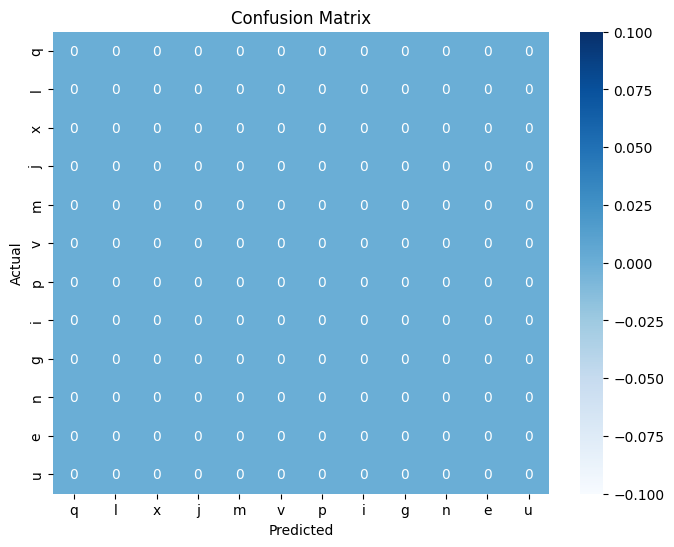

In [106]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_letters, yticklabels=confusion_letters)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#GROUND TRUTH:  lay blue by d four now
#PREDICTED: lay bleen at ninre aoaon s7 govornik

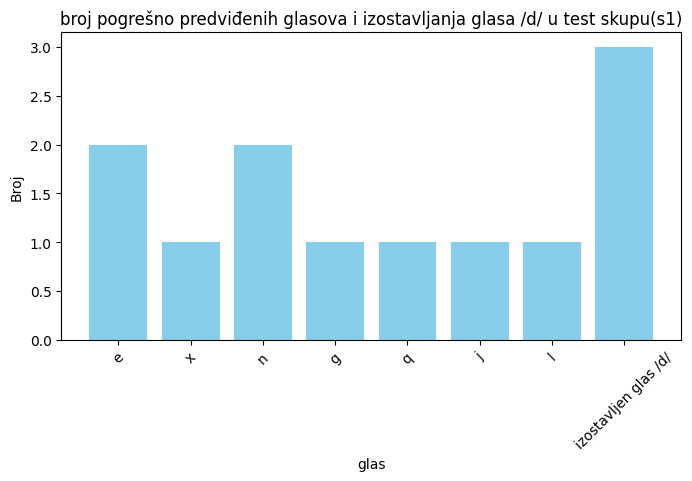

Errors in representation of special letters:
Missed e: 2 times
Missed x: 1 times
Missed n: 2 times
Missed g: 1 times
Missed q: 1 times
Missed j: 1 times
Missed l: 1 times


In [118]:
error_counts = {key: errors[key] for key in errors.keys()}
error_counts['<missing>'] = sum(1 for letter in real_letters if letter in special_letters and letter not in predicted_letters)
updated_error_counts = {}
for key, value in error_counts.items():
    if key.startswith('Missed '):
        # Ukloni 'Missed ' sa početka ključa
        new_key = key.replace('Missed ', '')
    elif key == '<missing>':
        # Zamenite '<missing>' sa 'izostavljeno'
        new_key = 'izostavljen glas /d/'
    else:
        # Održi postojeći ključ
        new_key = key
    updated_error_counts[new_key] = value
# Bar dijagram
plt.figure(figsize=(8, 4))
plt.bar(updated_error_counts.keys(), error_counts.values(), color='skyblue')
plt.xlabel('glas')
plt.ylabel('Broj')
plt.title('broj pogrešno predviđenih glasova i izostavljanja glasa /d/ u test skupu(s1)')
plt.xticks(rotation=45)
plt.show()

# Ispis broja grešaka
print("Errors in representation of special letters:")
for error, count in errors.items():
    print(f"{error}: {count} times")

In [108]:
error_counts.keys()

dict_keys(['Missed e', 'Missed x', 'Missed n', 'Missed g', 'Missed q', 'Missed j', 'Missed l', '<missing>'])